<a href="https://colab.research.google.com/github/ostadnavid/keras_flowers_classification/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# flowers model

## imports

In [1]:
import tensorflow as tf
import keras
from keras import utils, layers

import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
import os, shutil

from google.colab import files

files.upload() # upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navidstark","key":"1b6efeee5b47b3c758f67151e2f108f6"}'}

## getting data ready and exploring it

In [2]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle

!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

!unzip -qq 5-flower-types-classification-dataset.zip

!ls flower_images

 97% 235M/242M [00:01<00:00, 184MB/s]
100% 242M/242M [00:01<00:00, 141MB/s]
Lilly  Lotus  Orchid  Sunflower  Tulip


In [3]:
dataset_path = Path('./flower_images')

def count_images():
  counts = {}
  for dir in dataset_path.glob('*'):
    images_names = [i.name for i in dir.glob('*.jpg')]
    counts[dir.name] = {'counts':len(images_names),
                        'names':images_names}
  
  return counts

meta_data_dataset = count_images()

In [4]:
new_dataset_path = Path('./dataset')

def create_subsets():
  train, val, test = 700, 800, 1000


  for subset in ('train', 'val', 'test'):
    for category in meta_data_dataset.keys():
      os.makedirs(new_dataset_path / subset / category)
  
  is_created = []
  for subset in ('train', 'val', 'test'):
    for category in meta_data_dataset.keys():
      is_created.append((new_dataset_path / subset / category).exists())

  print(all(is_created))

  i = 0
  while i != 3:
    print(f'processing {i}')
    for category in meta_data_dataset.keys():
      image_names = [img for img in meta_data_dataset[category]['names']]

      if i == 0:
        selected_image_names = image_names[:train]

        for img_name in selected_image_names:
          os.rename(src = dataset_path / category / img_name,
                    dst = new_dataset_path / 'train' / category / img_name)
      elif i == 1:
        selected_image_names = image_names[train:val]

        for img_name in selected_image_names:
          os.rename(src = dataset_path / category / img_name,
                    dst = new_dataset_path / 'val' / category / img_name)
      else:
        selected_image_names = image_names[val:test]

        for img_name in selected_image_names:
          os.rename(src = dataset_path / category / img_name,
                    dst = new_dataset_path / 'test' / category / img_name)
      
    i +=1

create_subsets()

True
processing 0
processing 1
processing 2


In [5]:
total_amounts = []

for subset in ('train', 'val', 'test'):
  for category in meta_data_dataset.keys():
    total_images = len(list((new_dataset_path / subset / category).glob('*')))
    total_amounts.append(f'{subset}/{category}/{total_images}')

total_amounts

['train/Lotus/700',
 'train/Tulip/700',
 'train/Lilly/700',
 'train/Orchid/700',
 'train/Sunflower/700',
 'val/Lotus/100',
 'val/Tulip/100',
 'val/Lilly/100',
 'val/Orchid/100',
 'val/Sunflower/100',
 'test/Lotus/200',
 'test/Tulip/200',
 'test/Lilly/199',
 'test/Orchid/200',
 'test/Sunflower/200']

In [6]:
train_dataset = utils.image_dataset_from_directory(
    new_dataset_path / 'train'
)
val_dataset = utils.image_dataset_from_directory(
    new_dataset_path / 'val'
)
test_dataset = utils.image_dataset_from_directory(
    new_dataset_path / 'test'
)

Found 3500 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 999 files belonging to 5 classes.


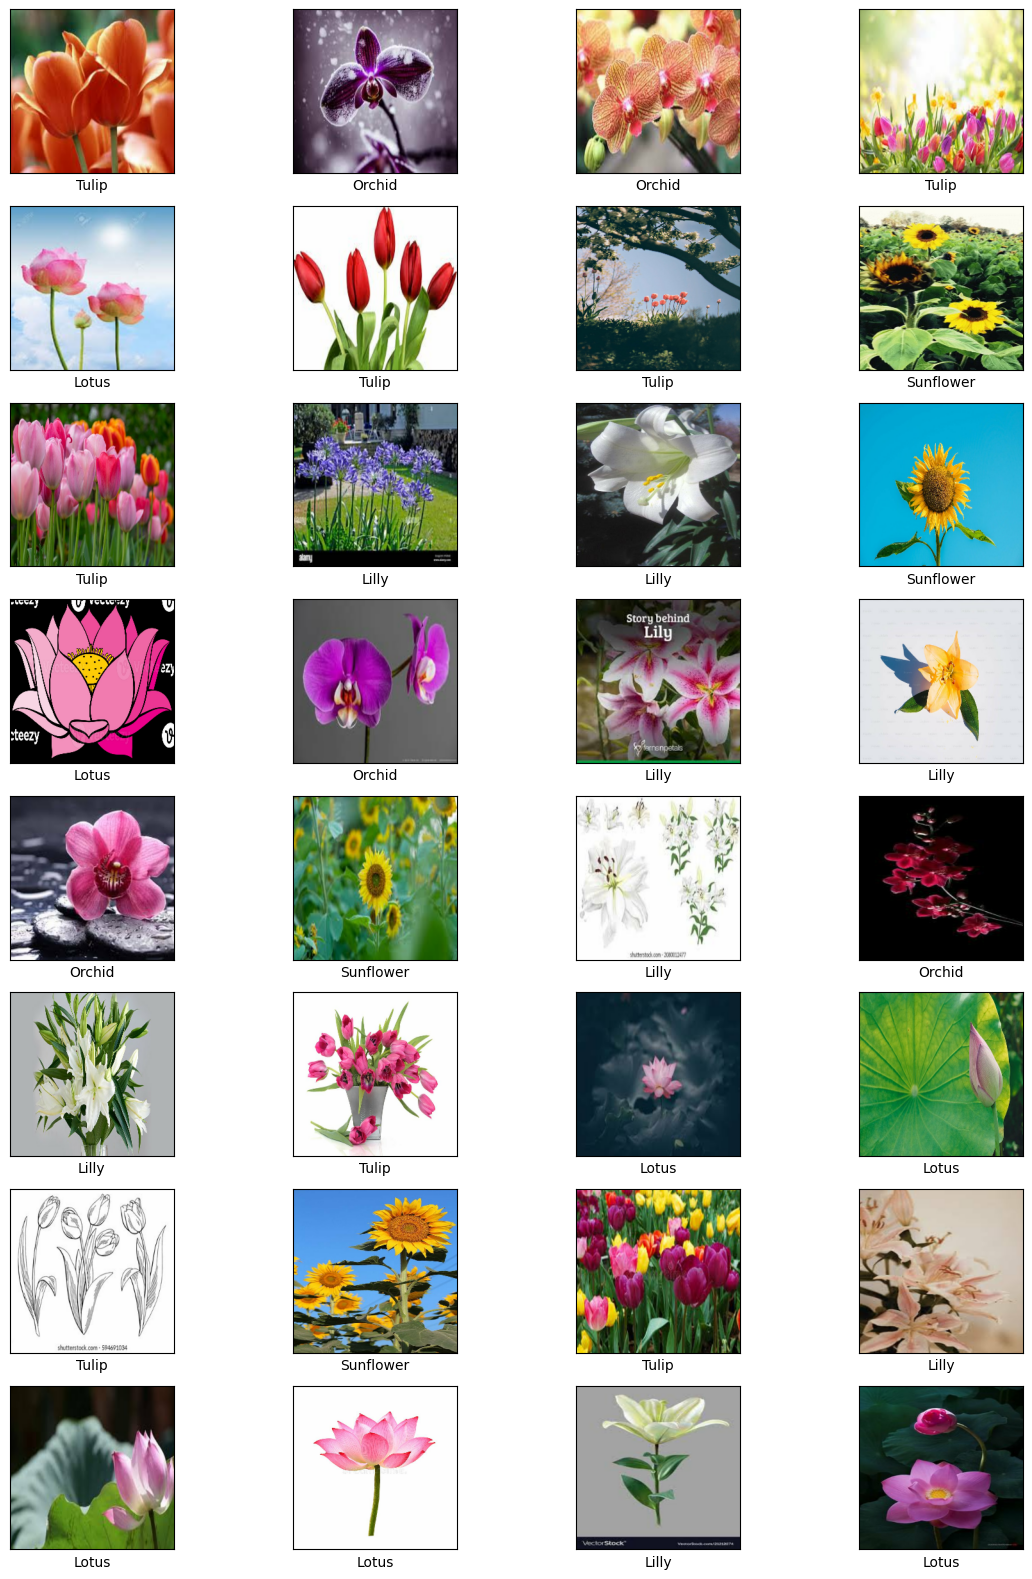

In [7]:
class_names = ['Lilly','Lotus','Orchid','Sunflower','Tulip']

for (img, label) in train_dataset:
  plt.figure(figsize=(14, 20))
  for i in range(32):
    plt.subplot(8, 4, i+1)
    plt.imshow(img[i].numpy().astype('int32'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[label[i].numpy().item()])
  plt.show()
  break

## model

In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('HORIZONTAL'.lower()),
    layers.RandomRotation(.1),
    layers.RandomZoom(.1),
    layers.RandomContrast(.08)
])

def get_model():
  inputs = layers.Input((256, 256, 3))
  _ = data_augmentation(inputs)
  _ = layers.Rescaling(1./255)(_)
  _ = layers.Conv2D(filters=64, padding='same', kernel_size=2, activation='relu')(_)
  _ = layers.Conv2D(filters=64, padding='same', kernel_size=2, activation='relu')(_)
  _ = layers.MaxPooling2D(pool_size=2)(_)
  _ = layers.Conv2D(filters=128, padding='same', kernel_size=2, activation='relu')(_)
  _ = layers.MaxPooling2D(pool_size=2)(_)
  _ = layers.Conv2D(filters=256, padding='same', kernel_size=2, activation='relu')(_)
  _ = layers.MaxPooling2D(pool_size=2)(_)
  _ = layers.Conv2D(filters=256, padding='same', kernel_size=2, activation='relu')(_)
  _ = layers.MaxPooling2D(pool_size=2)(_)
  _ = layers.Conv2D(filters=256, padding='same', kernel_size=2, activation='relu')(_)
  _ = layers.Flatten()(_)
  _ = layers.Dropout(.5)(_)
  outputs = layers.Dense(5, activation='softmax')(_)

  return keras.Model(inputs, outputs)

model = get_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      832       
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 64)      16448     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                           

In [12]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.LearningRateScheduler(
        lambda epoch, lr : lr if epoch < 10 else lr * tf.math.exp(-.1)
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=4
    )
]

history = model.fit(train_dataset,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_dataset,
          verbose=0)

## evaluate the model

In [25]:
best_model = keras.models.load_model('best_model.keras')

best_model.evaluate(test_dataset)

32/32 [==============================] - 3s 78ms/step - loss: 0.6220 - accuracy: 0.8078


[0.6220480799674988, 0.8078078031539917]

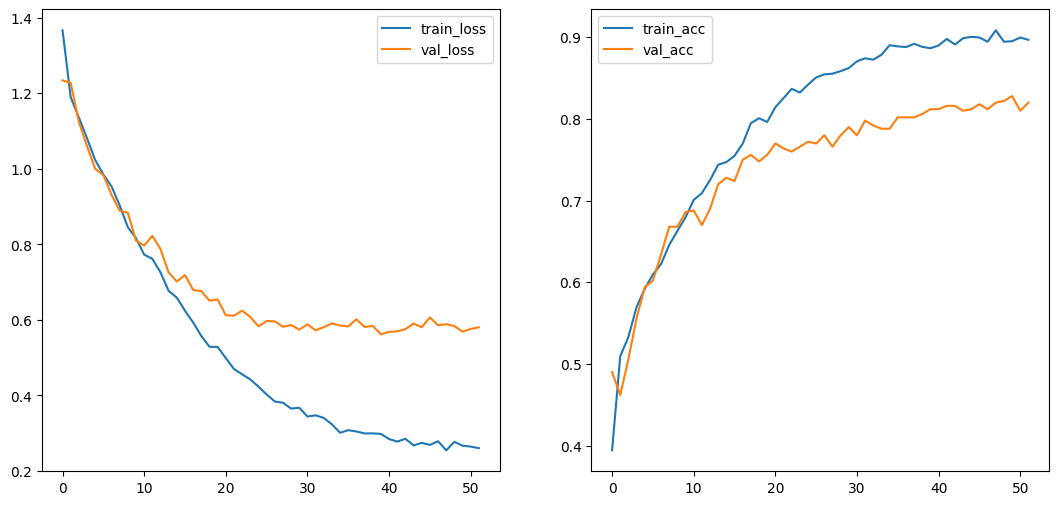

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.show()

In [27]:
import numpy as np

def make_pred(img_array, model, plot=True):
  pred = model.predict(np.expand_dims(img_array, 0), verbose=0)
  pred_label = np.argmax(pred, axis=1).item()

  pred = np.round(pred.squeeze(), 3)
  if plot:
    plt.figure(figsize=(13, 7))
    plt.subplot(1, 2, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_array.astype('int32'))
    plt.xlabel(f'{class_names[pred_label]} {round((np.max(pred)*100).item())}%')

    plt.subplot(1, 2, 2)
    plt.grid(False)
    plt.xticks(range(5), class_names, rotation=45)
    plt.yticks()
    thisplot = plt.bar(range(5), pred, color='#777777')
    plt.ylim([0, 1])
    
    thisplot[pred_label].set_color('blue')

    plt.show()

  return pred

def get_img_in_arr(path):
  img = utils.load_img(path, target_size=(256, 256))
  img_arr = utils.img_to_array(img)

  return img_arr

In [28]:
import urllib.request

def get_image_from_internet(url):
  urllib.request.urlretrieve(url, 'image.jpg')

  image_sample = get_img_in_arr('image.jpg')

  return image_sample

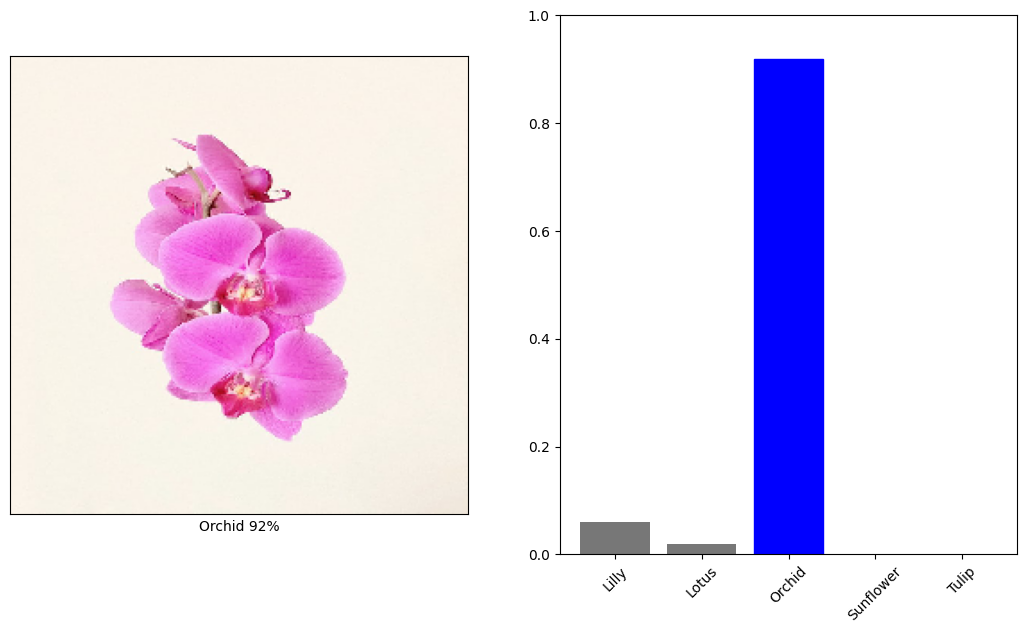

array([0.061, 0.019, 0.919, 0.   , 0.   ], dtype=float32)

In [29]:
image_url = 'https://images.unsplash.com/photo-1610397648930-477b8c7f0943?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8b3JjaGlkfGVufDB8fDB8fHww&auto=format&fit=crop&w=600&q=60'
image = get_image_from_internet(image_url)
make_pred(image, model=best_model)